In [1]:
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.predictor import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
import numpy as np
from deorbit.observer import Observer
from deorbit.utils.constants import EARTH_RADIUS


In [31]:
save_path = "eg/EKF_example_3D/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)


if sim_data is None or sim_config is None:
    np.random.seed(0)
    sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 5, 5, 7820)),
        noise_types = {"gaussian": {"noise_strength": 0.005}, "impulse": {"impulse_strength": 0.03, "impulse_probability": 1e-5}},
        time_step=2,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

Running simulation with RK4 integrator
Ran 11347 iterations at time step of 2.0 seconds
Impacted at [-931298.01581439 -201545.59097718 6299272.29877072] at velocity [ 143.24110984 -637.5010173   -49.12008785] at simulated time 22694.0s.
Simulation finished in 3.37500 seconds


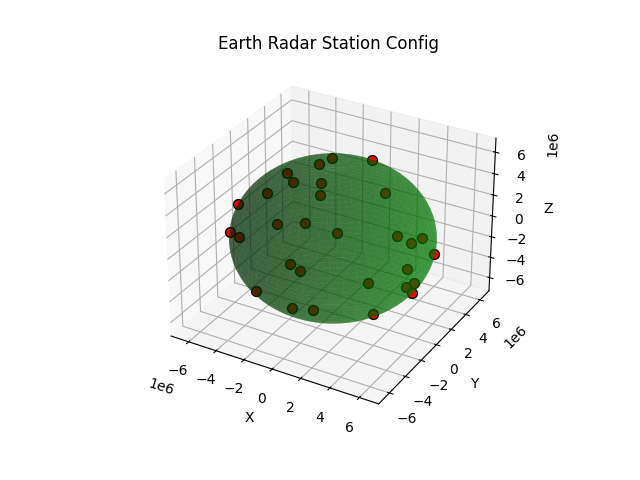

In [32]:
#initialising observer class with sim data
obs = Observer(number_of_radars=30, dim=3)

sim_states = sim_data.state_array()
sim_times = sim_data.times

obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=100)

observation_times = obs.observed_times
observation_states = obs.observed_states
observed_covariances = obs.observed_covariances

observations = (observation_states, observation_times)
#dim = sim_data.state_array().shape[1]

obs.plot_config()


In [33]:


# Define process and measurement noise covariance matrices, think this noise should be alot bigger
Q = np.diag([0.1, 0.1, 0.1, 0.01, 0.01, 0.01])#process noise
P = np.eye(sim_data.state_array().shape[1]) #error covariance matrix - represents uncertainty in state estimation

# Measurement matrix H (assuming all states are measured directly??????) -- for now
H = np.eye(sim_data.state_array().shape[1])

dt = sim_config.simulation_method_kwargs.time_step

#initialising 3D EKF
ekf = EKF(dim=3)

estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt=dt, Q=Q, R=observed_covariances, P=P, H=H)

100%|██████████| 41/41 [00:04<00:00,  7.00it/s]

KeyboardInterrupt: 

In [7]:
print(len(estimated_traj))


802
[-2.23061951e+06 -2.47376852e+04  6.29975706e+06 -5.49613121e+03
 -2.82780570e+03 -4.05261748e+03]


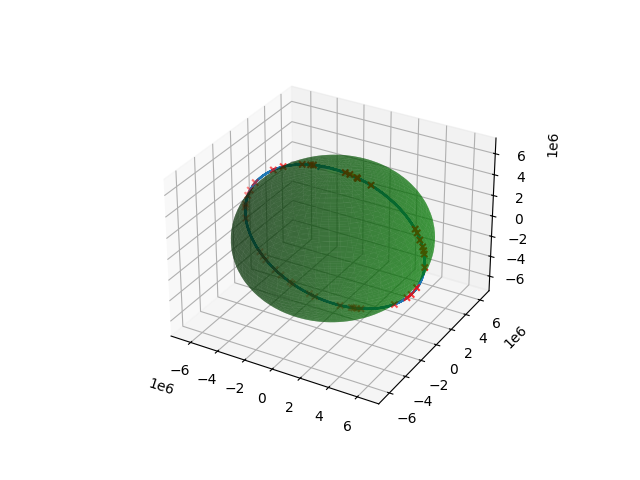

In [34]:
%matplotlib widget
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")

#plotting EARTH
r = EARTH_RADIUS

theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(phi)

ax.plot_surface(x, y, z, color="g", alpha=0.5)

splice = slice(470, 502)

#plotting simulated 'true' trajectory
true_traj = sim_data.state_array()[:, :3]
ax.plot(true_traj[:, 0], true_traj[:, 1], true_traj[:, 2], label='True Trajectory')

#plotting observations
ax.scatter(observation_states[:, 0], observation_states[:, 1], observation_states[:, 2], marker='x', color='r', label='Noisy Measurements', s=20)

#plotting prediction
ax.plot(estimated_traj[:, 0][splice], estimated_traj[:, 1][splice], estimated_traj[:, 2][splice], label = 'Estimated Trajectory')

plt.show()


In [30]:
print(sim_data.state_array()[splice][-10:])

[[ 2.48497658e+06  5.06611413e+02  6.02868070e+06 -7.22860634e+03
   2.23003636e-01  2.97931419e+03]
 [ 2.47051230e+06  5.07085037e+02  6.03462193e+06 -7.23569381e+03
   2.40050733e-01  2.96189717e+03]
 [ 2.45603374e+06  5.07478193e+02  6.04052839e+06 -7.24284885e+03
   1.14970431e-01  2.94458183e+03]
 [ 2.44154098e+06  5.07715413e+02  6.04640016e+06 -7.24990129e+03
   1.16913868e-01  2.92718376e+03]
 [ 2.42703418e+06  5.07996894e+02  6.05223720e+06 -7.25688512e+03
   1.42336030e-01  2.90986886e+03]
 [ 2.41251349e+06  5.08295215e+02  6.05803956e+06 -7.26381738e+03
   1.48749787e-01  2.89247582e+03]
 [ 2.39797886e+06  5.08574247e+02  6.06380721e+06 -7.27076866e+03
   1.20591613e-01  2.87513542e+03]
 [ 2.38343039e+06  5.08830836e+02  6.06954008e+06 -7.27767273e+03
   8.92058129e-02  2.85774226e+03]
 [ 2.36886825e+06  5.09066068e+02  6.07523797e+06 -7.28445699e+03
   1.72440818e-01  2.84014943e+03]
 [ 2.35429250e+06  5.09425810e+02  6.08090079e+06 -7.29131567e+03
   1.94561452e-01  2.8226